In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
import shap
from ucimlrepo import fetch_ucirepo 

/Users/start/opt/anaconda3/envs/shap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The highest accuracy and its corresponding dataset(gbt, Explained_variance_components)

In [2]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 

# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 

# Remove duplicate rows
combined = pd.concat([X, y], axis=1).drop_duplicates()

# Check for identical X with different y and remove them
inconsistent_indices = combined[combined.duplicated(subset=combined.columns[:-1], keep=False) & combined.duplicated(subset=[combined.columns[-1]], keep=False)].index
if not inconsistent_indices.empty:
    combined = combined.drop(inconsistent_indices)

# Separate features and target after cleaning
X = combined.iloc[:, :-1]
y = pd.DataFrame(combined.iloc[:, -1], columns=['Diabetes_binary'])

# Diet 
X['Diet'] = X['Fruits'] + X['Veggies']

# cardiovascular
X['cardiovascular'] = X['HighChol'] + X['HighBP']

# unhealthy_behavior
X['unhealthy_behavior'] = X['Smoker'] + X['HvyAlcoholConsump']

# healthcare
X['healthcare'] = np.where(
    (X['AnyHealthcare'] == 1) & (X['NoDocbcCost'] == 0), 3,
    np.where((X['AnyHealthcare'] == 1) & (X['NoDocbcCost'] == 1), 2,
    np.where((X['AnyHealthcare'] == 0) & (X['NoDocbcCost'] == 0), 1,
    np.where((X['AnyHealthcare'] == 0) & (X['NoDocbcCost'] == 1), 0,
    -1))))



In [3]:
def preprocess(X, features):
    X_clean = X[features]
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X_clean)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    return X_train, X_test, y_train, y_test

In [4]:
X_explained_variance_components_features = ['Fruits','HighChol','HighBP','PhysActivity','Smoker','HeartDiseaseorAttack',
                                            'Stroke','CholCheck','BMI','Diet','cardiovascular','unhealthy_behavior','healthcare']

X_train_explained, X_test_explained, y_train_explained, y_test_explained = preprocess(X, X_explained_variance_components_features)

In [6]:
# Gradient-Boosted Tree
gbt = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=50)
gbt.fit(X_train_explained, y_train_explained)
explainer = shap.TreeExplainer(gbt)

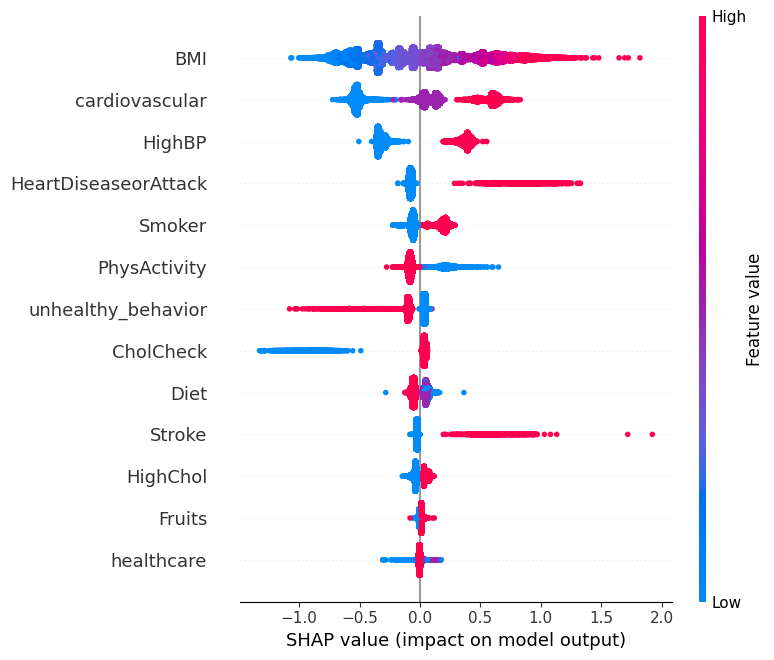

In [9]:
# Ensure that DataFrame is used in the SHAP visualization
shap_values = explainer.shap_values(X_test_explained)

# Use SHAP visualization and make sure feature names are shown on the diagrams
shap.summary_plot(shap_values, X_test_explained, feature_names=X_explained_variance_components_features)